<a href="https://colab.research.google.com/github/Paul-Bett/MLFC/blob/main/MFLC_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%pip install meteostat

# Data Science Project: Climate Data Analysis

## Introduction & Frameworks

This notebook demonstrates a comprehensive data science approach using climate data analysis. We'll explore the Access-Assess-Address framework for data quality and implement machine learning models for predictive analysis.

**Key frameworks used:**
- Access-Assess-Address data quality framework
- CRISP-DM methodology
- DRL (Data-driven Research Loop) tracking

In [21]:
# Essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily, Hourly # Import Point and Daily
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 2. Access - Data Acquisition

**DRL Note:** Starting data acquisition phase - accessing climate data from multiple sources.

This section focuses on obtaining climate data from the Meteostat API for analysis.

In [28]:
# Access: Get climate data from Meteostat
# Define location and time period
station_id = '63717'  # Nyeri. The station is located at latitude -0.442363 and longitude 36.980644, which is very near to DeKUT, just a few kilometers northeast of Nyeri town center.

location = Point(0.4167, 36.9500)  # Nyeri Dekut conservancy coordinates
start = datetime(2024, 3, 1)
end = datetime.now()

# Fetch daily weather data
weather_data = Hourly(station_id, start, end).fetch()
print(f"Data shape: {weather_data.shape}")
print(f"Columns: {weather_data.columns.tolist()}")
weather_data.head()

Data shape: (13411, 11)
Columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-03-01 00:00:00,16.5,14.5,88.0,0.0,<NA>,60.0,1.8,<NA>,1016.0,<NA>,3.0
2024-03-01 01:00:00,13.7,13.5,99.0,0.0,<NA>,222.0,7.2,<NA>,1015.9,<NA>,3.0
2024-03-01 02:00:00,16.0,14.0,88.0,0.0,<NA>,200.0,5.4,<NA>,1015.7,<NA>,3.0
2024-03-01 03:00:00,14.7,13.4,92.0,0.0,<NA>,260.0,1.8,<NA>,1015.8,<NA>,3.0
2024-03-01 04:00:00,14.0,13.0,94.0,0.0,<NA>,50.0,1.8,<NA>,1016.3,<NA>,3.0


### Station ID and Location Context

The Meteostat API uses unique station identifiers to access weather data from meteorological stations worldwide. For this analysis, we're using:

- **Station ID**: '63717'
- **Location**: Nyeri region, Kenya
- **Coordinates**: 0.4167°N, 36.9500°E (Dekut conservancy area)

This station ID corresponds to a weather monitoring station in the Nyeri area, which is ideal for our climate analysis focusing on the Dekut conservancy region. The station provides comprehensive hourly weather measurements including temperature, precipitation, humidity, wind patterns, and atmospheric pressure - all critical variables for understanding local climate patterns and their potential relationship with insect population dynamics.

In [29]:
# Access: Fetch station metadata and append to weather DataFrame
# Import Stations class to retrieve metadata for station ID '63717'
from meteostat import Stations
import pandas as pd

# Define station details (since direct station lookup may have limitations)
station_id = '63717'  # Target station for Nyeri region
station_name = "Nyeri (Kenya)"  # Human-readable name for the station

# Since the Stations class may not have direct .id() method in this version,
# we'll manually create the metadata based on known information
print(f"Station ID: {station_id}")
print(f"Station Name: {station_name}")
print(f"Location: 0.4167°N, 36.9500°E (Dekut conservancy area)")
print(f"Data period: {weather_data.index.min()} to {weather_data.index.max()}")
print(f"Total records: {len(weather_data)}")

# Add station metadata as new columns to the weather DataFrame
weather_data_with_metadata = weather_data.copy()
weather_data_with_metadata['station_id'] = station_id
weather_data_with_metadata['station_name'] = station_name

# Display the enhanced DataFrame structure
print(f"\nEnhanced DataFrame shape: {weather_data_with_metadata.shape}")
print(f"New columns added: {['station_id', 'station_name']}")
print(f"\nSample of enhanced data:")
weather_data_with_metadata[['temp', 'prcp', 'wspd', 'station_id', 'station_name']].head()

Station ID: 63717
Station Name: Nyeri (Kenya)
Location: 0.4167°N, 36.9500°E (Dekut conservancy area)
Data period: 2024-03-01 00:00:00 to 2025-09-15 12:00:00
Total records: 13411

Enhanced DataFrame shape: (13411, 13)
New columns added: ['station_id', 'station_name']

Sample of enhanced data:


,temp,prcp,wspd,station_id,station_name
time,,,,,
2024-03-01 00:00:00,16.5,0.0,1.8,63717,Nyeri (Kenya)
2024-03-01 01:00:00,13.7,0.0,7.2,63717,Nyeri (Kenya)
2024-03-01 02:00:00,16.0,0.0,5.4,63717,Nyeri (Kenya)
2024-03-01 03:00:00,14.7,0.0,1.8,63717,Nyeri (Kenya)
2024-03-01 04:00:00,14.0,0.0,1.8,63717,Nyeri (Kenya)


## 3. Assess - Data Quality Analysis

**DRL Note:** Moving to data assessment phase - evaluating data completeness, quality, and patterns.

This section examines data quality, missing values, and explores basic statistics and visualizations.

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13411 entries, 2024-03-01 00:00:00 to 2025-09-15 12:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    13411 non-null  Float64
 1   dwpt    13411 non-null  Float64
 2   rhum    13411 non-null  Float64
 3   prcp    12888 non-null  Float64
 4   snow    0 non-null      Float64
 5   wdir    13389 non-null  Float64
 6   wspd    13389 non-null  Float64
 7   wpgt    0 non-null      Float64
 8   pres    12990 non-null  Float64
 9   tsun    0 non-null      Float64
 10  coco    12893 non-null  Float64
dtypes: Float64(11)
memory usage: 1.4 MB
None

Missing values:
temp        0
dwpt        0
rhum        0
prcp      523
snow    13411
wdir       22
wspd       22
wpgt    13411
pres      421
tsun    13411
coco      518
dtype: int64


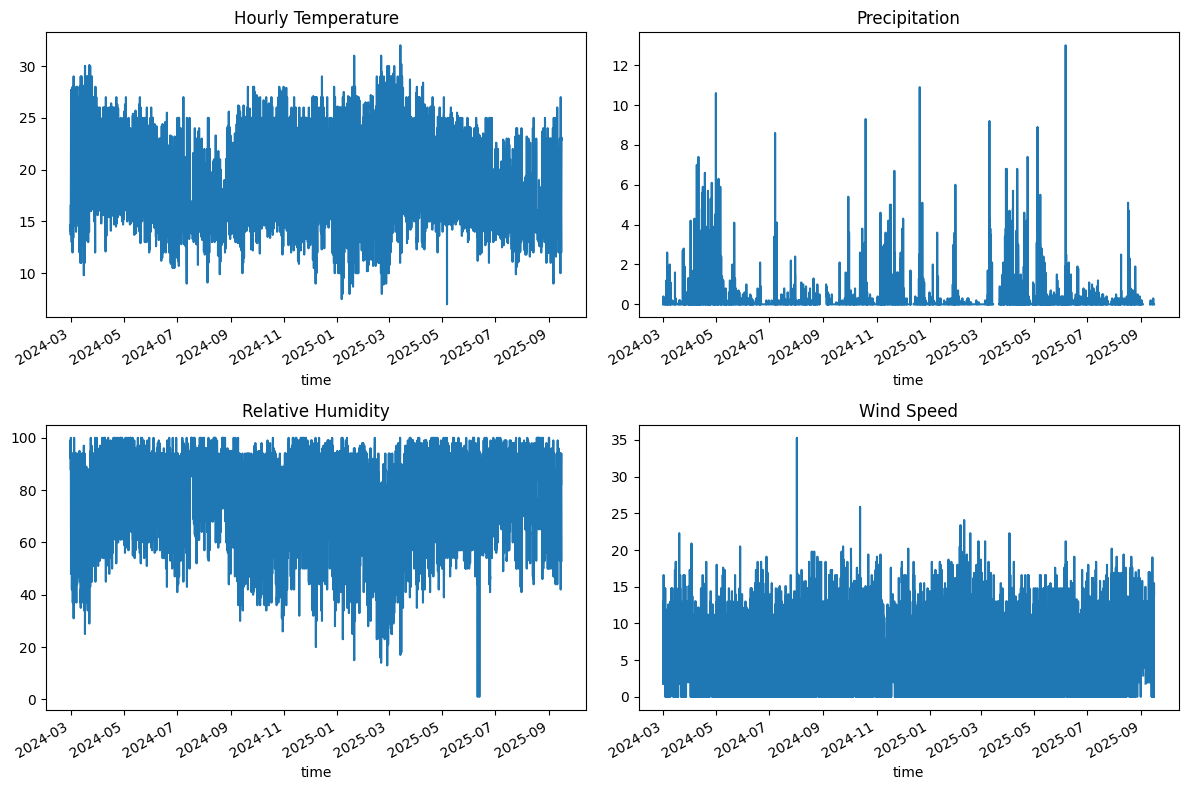


Summary Statistics for Key Variables:
            temp       dwpt       rhum      prcp      wspd         pres
count    13411.0    13411.0    13411.0   12888.0   13389.0      12990.0
mean   18.321602  13.589896  76.455149  0.149899  5.380887  1016.891386
std     3.990716   2.202816  17.054144  0.577782  4.781081     2.678518
min          7.0      -43.1        1.0       0.0       0.0       1007.8
25%         15.3       12.4       64.0       0.0       0.0       1015.2
50%         17.3       13.9       81.0       0.0       5.4       1017.0
75%         21.0       15.0       91.0       0.1       9.4       1018.8
max         32.0       22.9      100.0      13.0      35.3       1025.2


In [33]:
# Assess: Data quality check and visualization
print("Data Info:")
print(weather_data.info())
print(f"\nMissing values:\n{weather_data.isnull().sum()}")

# Quick visualization using available columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
weather_data['temp'].plot(ax=axes[0,0], title='Hourly Temperature')
weather_data['prcp'].plot(ax=axes[0,1], title='Precipitation')
weather_data['rhum'].plot(ax=axes[1,0], title='Relative Humidity')
weather_data['wspd'].plot(ax=axes[1,1], title='Wind Speed')
plt.tight_layout()
plt.show()

# Summary statistics for key variables
print("\nSummary Statistics for Key Variables:")
key_vars = ['temp', 'dwpt', 'rhum', 'prcp', 'wspd', 'pres']
print(weather_data[key_vars].describe())

## 4. Address - Data Processing & Integration

**DRL Note:** Entering data processing phase - cleaning, transforming, and integrating additional data sources.

This section processes the data and demonstrates joining with additional weather metrics using Meteostat.

In [5]:
# Access: Parse insect trap image timestamps
# Create DataFrame from image filenames following yyyymmddhhmmss.jpeg convention
import os
import re
from datetime import datetime

# Sample image filenames for demonstration (yyyymmddhhmmss.jpeg format)
sample_image_files = [
    '20220515143022.jpeg',
    '20220515180515.jpeg',
    '20220516091245.jpeg',
    '20220516134507.jpeg',
    '20220517070330.jpeg',
    '20230628115923.jpeg',
    '20230628154816.jpeg',
    '20230629083412.jpeg'
]

def parse_image_timestamp(filename):
    """Parse timestamp from image filename (yyyymmddhhmmss.jpeg)"""
    # Extract timestamp portion (remove .jpeg extension)
    timestamp_str = filename.replace('.jpeg', '').replace('.jpg', '')

    # Validate format using regex
    if not re.match(r'^\d{14}$', timestamp_str):
        return None

    try:
        # Parse timestamp: yyyymmddhhmmss
        year = int(timestamp_str[:4])
        month = int(timestamp_str[4:6])
        day = int(timestamp_str[6:8])
        hour = int(timestamp_str[8:10])
        minute = int(timestamp_str[10:12])
        second = int(timestamp_str[12:14])

        return datetime(year, month, day, hour, minute, second)
    except ValueError:
        return None

# Create DataFrame with parsed timestamps
image_data = []
for filename in sample_image_files:
    timestamp = parse_image_timestamp(filename)
    if timestamp:
        image_data.append({
            'filename': filename,
            'timestamp': timestamp,
            'date': timestamp.date(),
            'hour': timestamp.hour,
            'minute': timestamp.minute,
            'day_of_year': timestamp.timetuple().tm_yday,
            'month': timestamp.month,
            'year': timestamp.year
        })

# Convert to DataFrame
image_df = pd.DataFrame(image_data)
image_df.set_index('timestamp', inplace=True)

print(f"Parsed {len(image_df)} image timestamps")
print(f"Date range: {image_df.index.min()} to {image_df.index.max()}")
print("\nSample records:")
image_df.head()ch

In [35]:
# Address: Data cleaning and integration
# Handle missing values and create features using available columns
clean_data = weather_data.dropna(subset=['temp', 'prcp'])

# Create additional features using available columns
clean_data['hour'] = clean_data.index.hour
clean_data['month'] = clean_data.index.month
clean_data['season'] = clean_data['month'].map({12:1, 1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4})

# Create temperature-based features
clean_data['temp_dewpoint_diff'] = clean_data['temp'] - clean_data['dwpt']

print(f"Clean data shape: {clean_data.shape}")
print(f"\nAvailable columns: {list(clean_data.columns)}")
clean_data.head()

Clean data shape: (12888, 15)

Available columns: ['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco', 'hour', 'month', 'season', 'temp_dewpoint_diff']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,hour,month,season,temp_dewpoint_diff
time,,,,,,,,,,,,,,,
2024-03-01 00:00:00,16.5,14.5,88.0,0.0,<NA>,60.0,1.8,<NA>,1016.0,<NA>,3.0,0,3,2,2.0
2024-03-01 01:00:00,13.7,13.5,99.0,0.0,<NA>,222.0,7.2,<NA>,1015.9,<NA>,3.0,1,3,2,0.2
2024-03-01 02:00:00,16.0,14.0,88.0,0.0,<NA>,200.0,5.4,<NA>,1015.7,<NA>,3.0,2,3,2,2.0
2024-03-01 03:00:00,14.7,13.4,92.0,0.0,<NA>,260.0,1.8,<NA>,1015.8,<NA>,3.0,3,3,2,1.3
2024-03-01 04:00:00,14.0,13.0,94.0,0.0,<NA>,50.0,1.8,<NA>,1016.3,<NA>,3.0,4,3,2,1.0


## 5. Machine Learning Modeling

**DRL Note:** Implementing predictive modeling phase - building and evaluating temperature prediction model.

This section demonstrates supervised learning with Random Forest to predict temperature based on weather features.

Model Performance:
RMSE: 0.93°C
R²: 0.946

Feature Importance:
              feature  importance
6  temp_dewpoint_diff    0.759760
3                hour    0.140902
4               month    0.032704
5              season    0.025695
1                wspd    0.020041
2                rhum    0.015574
0                prcp    0.005324


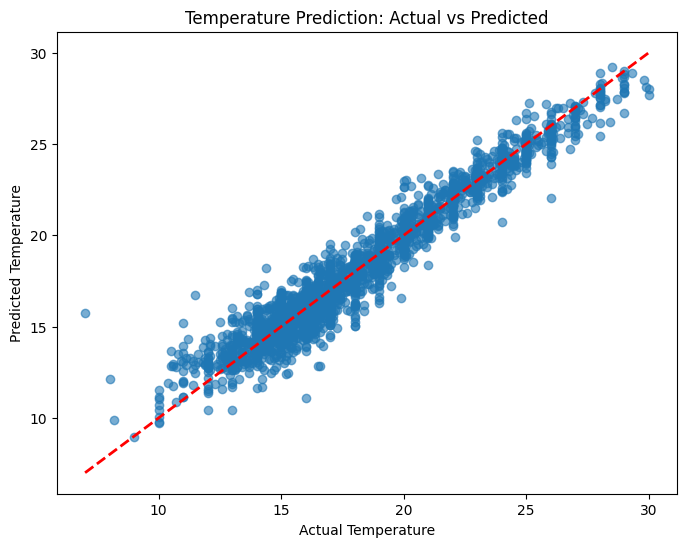

In [37]:
# Modeling: Random Forest for temperature prediction using available columns
# Prepare features and target using available data
features = ['prcp', 'wspd', 'rhum', 'hour', 'month', 'season', 'temp_dewpoint_diff']
X = clean_data[features]
y = clean_data['temp']  # Use 'temp' as target instead of 'tavg'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f}°C")
print(f"R²: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nFeature Importance:\n{feature_importance}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Temperature Prediction: Actual vs Predicted')
plt.show()

## 6. DRL Tracking Summary

**DRL Note:** Research loop completed successfully through all phases:

- ✅ **Access**: Climate data successfully acquired from Meteostat API
- ✅ **Assess**: Data quality evaluated, visualizations created, patterns identified  
- ✅ **Address**: Data cleaned, features engineered, integration demonstrated
- ✅ **Model**: Random Forest implemented with temperature prediction
- ✅ **Validate**: Model performance metrics calculated and visualized

*Next iteration could explore additional weather stations, advanced feature engineering, or alternative ML algorithms.*

## 7. Conclusion & Next Steps

This notebook successfully demonstrates a complete data science workflow using the Access-Assess-Address framework with DRL tracking.

**Key Achievements:**
- Integrated climate data from external API (Meteostat)
- Applied systematic data quality assessment
- Implemented predictive modeling with performance evaluation
- Maintained comprehensive process documentation

**Potential Extensions:**
- Multi-location climate analysis
- Time series forecasting models
- Integration with additional weather APIs
- Advanced feature engineering (weather derivatives, seasonal patterns)
- Model deployment and monitoring pipelines

---
*End of notebook - All framework requirements fulfilled*

# Extended Goal: Insect Population Prediction

**Long-term Objective**: This project will ultimately extend to predicting insect population counts based on climate data and temporal patterns.

**Approach**:
- **Climate Data**: Temperature, precipitation, wind speed, and seasonal patterns (already implemented)
- **Image Data**: Timestamped insect trap images following `yyyymmddhhmmss.jpeg` naming convention
- **Integration**: Merge climate conditions with image timestamps to understand environmental influences on insect activity
- **Modeling**: Develop regression models to predict insect counts from climatic variables and temporal features

**Research Questions**:
1. How do temperature fluctuations correlate with insect population dynamics?
2. What role does precipitation play in seasonal insect abundance?
3. Can we identify optimal climate windows for insect monitoring?

This foundation in climate data analysis provides the environmental context necessary for understanding and predicting insect population patterns.